In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage as ski
import bm3d
from optics import grating, circle_lowpass
from noise import gauss_noise, poisson_noise, salt_pepper_noise, random_noise


(512, 512) 0.0 1.0


<Figure size 640x480 with 0 Axes>

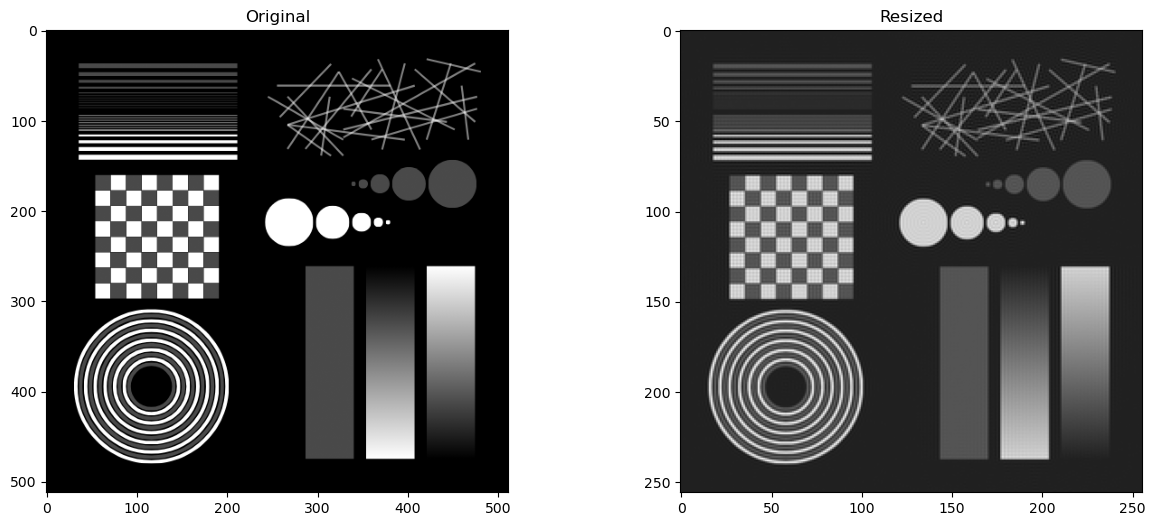

In [ ]:
plt.set_cmap('gray')

# synthetic = ski.img_as_float(ski.io.imread('Synthetic_image_8bit.tif'))
# synthetic = ski.transform.resize_local_mean(synthetic, (512, 512))

synthetic = ski.img_as_float(ski.color.rgb2gray(ski.io.imread('source_images\Synthetic512.png')))

print(np.shape(synthetic), np.min(synthetic), np.max(synthetic))

synthetic128 = circle_lowpass(synthetic, synthetic.shape[-1]//4)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].imshow(synthetic)
ax[0].set_title("Original")
ax[1].imshow(synthetic128)
ax[1].set_title("Resized")
plt.show()

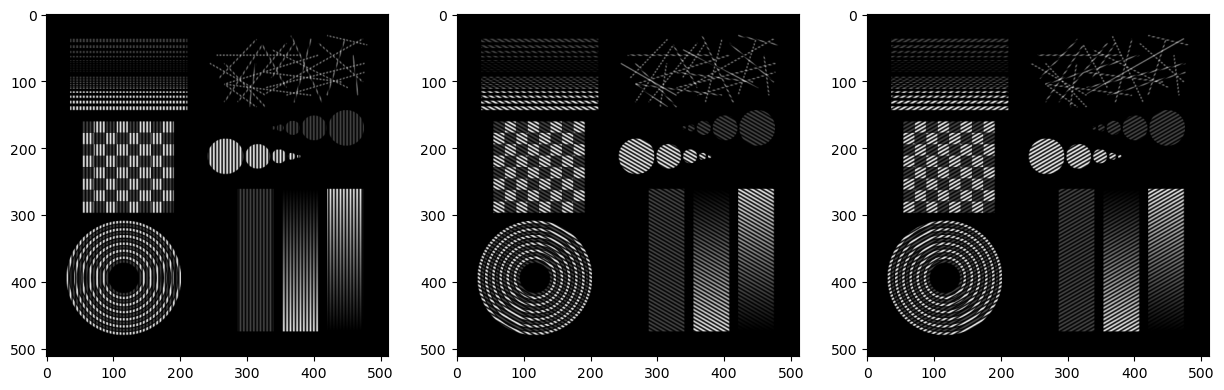

In [15]:
Wavelength = 5
grate_0_0 = grating(512, Wavelength, 120, 0)
synthetic_grated = np.zeros((9, synthetic.shape[0], synthetic.shape[1]))

for i in range(3):
    for j in range(3):
        synthetic_grated[3*i + j] = synthetic * grating(len(synthetic), Wavelength, 120 * i,  120 * j)
        
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
for i in range(3):
    ax[i].imshow(synthetic_grated[3*i])
plt.show()

In [ ]:
# Add noise to the images
percentage = 0.2
synthetic_grated_gaussian = gauss_noise(synthetic_grated, percentage)
synthetic_grated_poisson = poisson_noise(synthetic_grated, percentage)
synthetic_grated_saltpepper = salt_pepper_noise(synthetic_grated, percentage)
synthetic_grated_random = random_noise(synthetic_grated, percentage)

# Apply low-pass filter
radius = synthetic_grated.shape[-1]//4
synthetic_grated_gaussian_256 = circle_lowpass(synthetic_grated_gaussian, radius)
synthetic_grated_poisson_256 = circle_lowpass(synthetic_grated_poisson, radius)
synthetic_grated_saltpepper_256 = circle_lowpass(synthetic_grated_saltpepper, radius)
synthetic_grated_random_256 = circle_lowpass(synthetic_grated_random, radius)


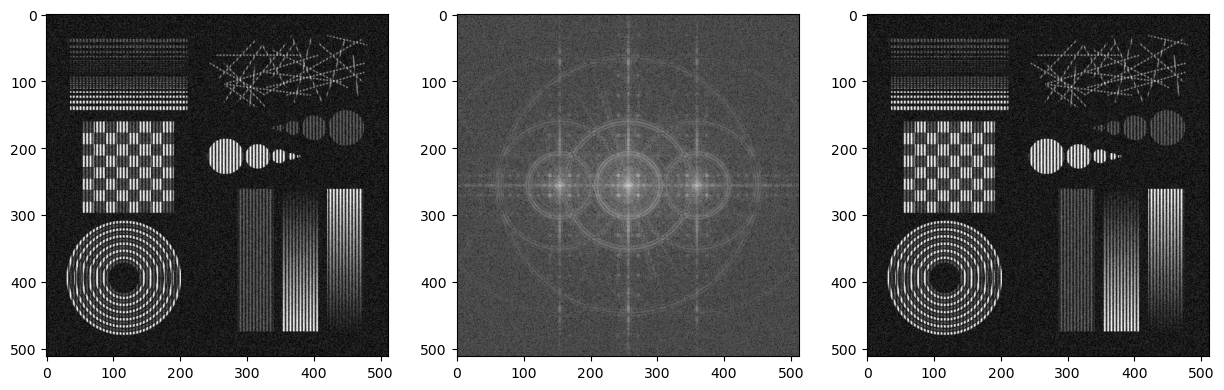

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

img = synthetic_grated_random[0]
ax[0].imshow(img)
ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)
ax[1].imshow(np.log(np.abs(ft)+1))
ft = np.fft.ifftshift(ft)
reconstruct = np.fft.ifft2(ft)  # Inverse FFT
ax[2].imshow(np.real(reconstruct))


In [18]:
synthetic_grated_256 = fourier_lowpass_filter(synthetic_grated, radius) # Ground truth
noisy_image = synthetic_grated_saltpepper_256

noisy_PSNR = np.zeros(9)
noisy_SSIM = np.zeros(9)
for i in range(9):
    noisy_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], noisy_image[i])
    noisy_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], noisy_image[i], data_range=1)

print("Noisy PSNR: ", np.mean(noisy_PSNR))
print("Noisy SSIM: ", np.mean(noisy_SSIM))
# ski.io.imsave('images/synthetic_grated_256.tiff', synthetic_grated_256)

Noisy PSNR:  28.695954281565818
Noisy SSIM:  0.7603849469382807


In [19]:
#Gaussian filter
sigma = 0.2 # 1% 0.2
gaussian_synthetic_grated_256 = ski.filters.gaussian(noisy_image, sigma)

gauss_PSNR = np.zeros(9)
gauss_SSIM = np.zeros(9)

for i in range(9):
    gauss_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], gaussian_synthetic_grated_256[i])
    gauss_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], gaussian_synthetic_grated_256[i], data_range=1)
    
print(np.mean(gauss_PSNR))
print(np.mean(gauss_SSIM))

# ski.io.imsave('images/gaussian_synthetic_grated_256.tiff', gaussian_synthetic_grated_256)

28.695992055166514
0.7603884157567503


In [20]:
# Wiener filter
psf_size = 3
psf = np.outer(np.hanning(psf_size), np.hanning(psf_size))  # Approximate Gaussian PSF
psf /= psf.sum()
wiener_synthetic_grated_256 = np.zeros((9, 256, 256))

balance = 0.002 # 1% 0.0001

for i in range(9):
    wiener_synthetic_grated_256[i] = ski.restoration.wiener(noisy_image[i], psf, balance)

wiener_PSNR = np.zeros(9)
wiener_SSIM = np.zeros(9)

for i in range(9):
    wiener_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], wiener_synthetic_grated_256[i])
    wiener_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], wiener_synthetic_grated_256[i], data_range=1)
    
print(np.sum(wiener_PSNR, axis=0)/9)
print(np.sum(wiener_SSIM, axis=0)/9)
# ski.io.imsave('images/wiener_synthetic_grated_256.tiff', wiener_synthetic_grated_256)

28.704803014453702
0.7648426026230019


In [21]:
# Total variation filter
tv_synthetic_grated_256 = np.zeros((9, 256, 256))

weight = 0.005 # 1% 0.0002
for i in range(9):
    tv_synthetic_grated_256[i] = ski.restoration.denoise_tv_chambolle(noisy_image[i], weight)

tv_PSNR = np.zeros(9)
tv_SSIM = np.zeros(9)

for i in range(9):
    tv_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], tv_synthetic_grated_256[i])
    tv_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], tv_synthetic_grated_256[i], data_range=1)

print(np.sum(tv_PSNR, axis=0)/9)
print(np.sum(tv_SSIM, axis=0)/9)
# ski.io.imsave('images/tv_synthetic_grated_256.tiff', tv_synthetic_grated_256)

29.10667407191528
0.7909288768774749


In [22]:
# BM3D filter
bm3d_synthetic_grated_256 = np.zeros((9, 256, 256))
sigma_psd = 0.02 # 1% 0.001
for i in range(9):
    bm3d_synthetic_grated_256[i] = bm3d.bm3d(noisy_image[i], sigma_psd, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

bm3d_PSNR = np.zeros(9)
bm3d_SSIM = np.zeros(9)

for i in range(9):
    bm3d_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], bm3d_synthetic_grated_256[i])
    bm3d_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], bm3d_synthetic_grated_256[i], data_range=1)

print(np.mean(bm3d_PSNR))
print(np.mean(bm3d_SSIM))

# ski.io.imsave('images/bm3d_synthetic_grated_256.tiff', bm3d_synthetic_grated_256)

31.883644389240178
0.9106630997554545


In [23]:
# Create a dictionary to store the data
data = {
    'Filter': ['Gaussian', 'Wiener', 'TV', 'BM3D'],
    'PSNR': [np.mean(gauss_PSNR), np.mean(wiener_PSNR), np.mean(tv_PSNR), np.mean(bm3d_PSNR)],
    'SSIM': [np.mean(gauss_SSIM), np.mean(wiener_SSIM), np.mean(tv_SSIM), np.mean(bm3d_SSIM)]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(np.mean(noisy_PSNR))
print(np.mean(noisy_SSIM))
display(df.T)

28.695954281565818
0.7603849469382807


,0,1,2,3
Filter,Gaussian,Wiener,TV,BM3D
PSNR,28.695992,28.704803,29.106674,31.883644
SSIM,0.760388,0.764843,0.790929,0.910663
